In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.decoding as dec

In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5
chance_level = 1/8. if experiment=='gratings' else 0.5

In [7]:
analysis_type='by_ncells'
test_type='morph' #'morph_single'
class_name = 'morphlevel'
match_rfs = False
overlap_thr= 0.0 #[0, 0.25, 0.5]

test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)
print(basedir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/morph


## Output dirs

In [8]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)) or match_rfs:
    curr_dst_dir = os.path.join(basedir, 'controls')
else:
    curr_dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/morph/dff-ROC__stimulus__overlap0.00__C1.00
dff-ROC__stimulus__overlap0.00__C1.00


## Load

In [9]:
iterdf, missing = dec.load_iterdf(meta, class_name,experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
print(iterdf['overlap_thr'].unique())
print(iterdf['morphlevel'].unique())

(Li) Found 9 paths
(Lm) Found 9 paths
(V1) Found 10 paths
    checking for break-corrs
(Li) Found 0 paths
(Lm) Found 0 paths
(V1) Found 0 paths
[0.]
[  0 106  -1  14  27  40  53  66  79  92]


In [10]:
print(analysis_type, test_type)

grouper = ['morphlevel', 'intact', 'visual_area', 'condition', 'iteration']
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)):
    grouper.append('overlap_thr')
# if test_type is not None:
#     grouper.append('novel')
mean_df = dec.average_within_iterations_by_ncells(iterdf,
                     analysis_type=analysis_type,
                         test_type=test_type, grouper=grouper) 
if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("morphs:", mean_df['morphlevel'].unique())

by_ncells morph
['morphlevel', 'intact', 'visual_area', 'condition', 'iteration', 'n_cells', 'novel']
novel: [ True False]
conditions: ['data' 'shuffled']
morphs: [ -1   0  14  27  40  53  66  79  92 106]


In [11]:
max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
print(max_ncells)
n_iters = iterdf['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells]
xlabels = [1, 32, 96, max_ncells]

128


In [12]:
# Get unique datasets/match cell #s
finaldf = iterdf[iterdf['n_cells']<=max_ncells].copy()
max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
print(max_ncells)
finaldf['noise_corrs'] = ['intact' if f else 'shuffled' for f in finaldf['intact']]

128


In [13]:
iterdf['morphlevel'].unique()

array([  0, 106,  -1,  14,  27,  40,  53,  66,  79,  92])

In [14]:
cols = ['visual_area', 'intact', 'n_cells'] 

columns='n_cells'
index = ['visual_area', 'intact']

if test_type=='morph_single':
    cols.append('train_transform')
    index.append('train_transform')

mean_ = finaldf[finaldf['morphlevel']==0] # get basic performance

if test_type is not None:
    score_table = mean_[~(mean_.novel) & (mean_.condition=='data')]\
            .groupby(cols)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=index, columns=columns)
else:
    score_table = mean_[(mean_.condition=='data')]\
            .groupby(cols)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=index, columns=columns)
score_table

heldout_test_score                                          \
n_cells                           1         2         4         8         16    
visual_area intact                                                              
Li          True             0.532736  0.553462  0.581602  0.630529  0.671385   
Lm          True             0.531316  0.547090  0.567031  0.601021  0.637931   
V1          True             0.543222  0.561057  0.593500  0.634507  0.674176   

                                                            
n_cells                  32        64        96        128  
visual_area intact                                          
Li          True    0.714490  0.747973  0.783566  0.825014  
Lm          True    0.675310  0.708069  0.720414  0.752897  
V1          True    0.731055  0.754690  0.777586  0.811897

# test_type='morph'

In [15]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

In [16]:
count_cols = ['visual_area', 'morphlevel', 'condition', 'n_cells']
n_iterations = float(iterdf['iteration'].max()+1)
assert finaldf.groupby(count_cols).count().max().max()==n_iterations


In [19]:
datad = finaldf[(finaldf.condition=='data') & (finaldf.intact)]
mean_by_iter = datad.groupby(count_cols+['iteration']).mean()\
                     .reset_index()
mean_by_iter['morphlevel'].unique()

array([ -1,   0,  14,  27,  40,  53,  66,  79,  92, 106])

In [ ]:
metric

In [18]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

<IPython.core.display.Javascript object>


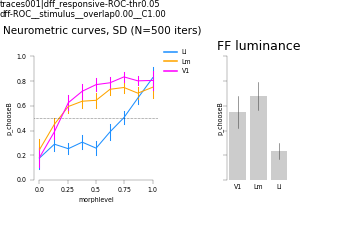

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/morph/dff-ROC__stimulus__overlap0.00__C1.00 neurometric_sd_iters


In [21]:
%matplotlib notebook
metric='p_chooseB'
curr_ncells = max_ncells
plotd = mean_by_iter[mean_by_iter.n_cells==curr_ncells]\
            .groupby(['visual_area', 'morphlevel', 'iteration']).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(4.5, 3), sharex=False, sharey=True)
ax=axn[0]
ax = dec.plot_pchooseb_by_area(plotd, metric=metric, area_colors=area_colors, ax=ax)
ax=axn[1]
ax = dec.plot_pchooseb_lum_by_area(plotd, metric=metric, ax=ax, color=0.8)

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.75, wspace=0.3)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
fig.text(0.01, 0.85, \
         'Neurometric curves, SD (N=%i iters)' % n_iterations)
figname = 'neurometric_sd_iters'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [407]:
import psignifit as ps

In [57]:
print(curr_ncells)
max_morph = float( iterdf['morphlevel'].max())
va='V1'
df0 = iterdf[(iterdf.condition=='data') & (iterdf.visual_area==va) 
           & (iterdf.n_cells==8) & (iterdf.morphlevel!=-1) & (iterdf.iteration==0)]\
          .copy() #.reset_index(drop=True)
#df0.index = df0['iteration']

df = df0[['morphlevel', 'n_samples', 'p_chooseB']].copy()
df['n_chooseB'] = df['n_samples']*df['p_chooseB']
df['morph_percent'] =df['morphlevel']/max_morph

128


In [59]:
df

,morphlevel,n_samples,p_chooseB,n_chooseB,morph_percent
0,0,29,0.137931,4.0,0.000000
1,106,29,0.862069,25.0,1.000000
6,14,145,0.262069,38.0,0.132075
8,27,145,0.234483,34.0,0.254717
10,40,145,0.310345,45.0,0.377358
12,53,145,0.324138,47.0,0.500000
14,66,145,0.434483,63.0,0.622642
16,79,145,0.634483,92.0,0.745283
18,92,145,0.675862,98.0,0.867925


<IPython.core.display.Javascript object>


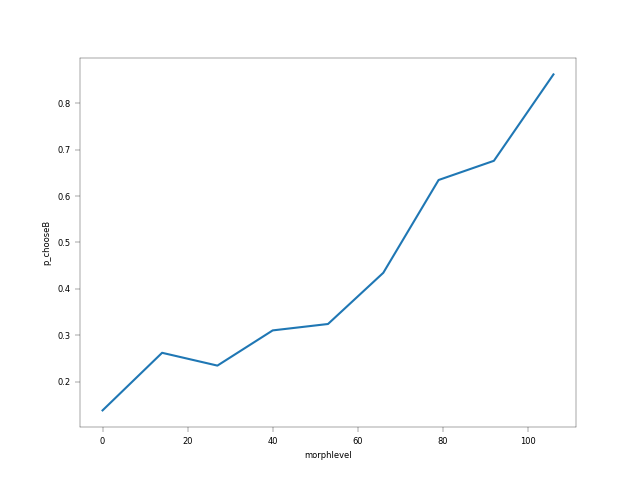

<AxesSubplot:xlabel='morphlevel', ylabel='p_chooseB'>

In [60]:
# test 1 
fig, ax = pl.subplots()
sns.lineplot(x='morphlevel', y='p_chooseB', data=df, ax=ax)

In [51]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)

opts = dict()
opts['sigmoidName'] = 'gauss'
opts['expType'] = 'YesNo'
opts['confP'] = np.tile(0.95, n_params)

# data: (np.array)
#     g[['morph_percent', 'n_chooseB', 'n_trials']]

In [52]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [62]:
df_test = df.sort_values(by='morphlevel')
df_test

,morphlevel,n_samples,p_chooseB,n_chooseB,morph_percent
0,0,29,0.137931,4.0,0.000000
6,14,145,0.262069,38.0,0.132075
8,27,145,0.234483,34.0,0.254717
10,40,145,0.310345,45.0,0.377358
12,53,145,0.324138,47.0,0.500000
14,66,145,0.434483,63.0,0.622642
16,79,145,0.634483,92.0,0.745283
18,92,145,0.675862,98.0,0.867925
1,106,29,0.862069,25.0,1.000000


In [54]:
fits = df_test.groupby(df_test.index).apply(dec.psignifit_neurometric)


In [55]:
fits

,threshold,width,lambda,gamma,eta
iteration,,,,,
0,0.769386,0.981086,8.778048e-09,2.115266e-01,1.154755e-05
1,-0.012182,1.004200,2.640277e-01,6.520764e-06,3.308272e-05
2,0.792948,1.063773,1.177454e-07,9.928006e-02,6.273829e-10
3,-0.111510,0.241835,4.324929e-01,5.712786e-08,2.256517e-04
4,-0.051993,0.957700,4.075355e-01,9.291451e-08,9.766766e-07
5,-0.072254,1.241937,1.865722e-01,7.796124e-04,1.725584e-09


In [459]:
data = df.loc[0][['morph_percent', 'n_chooseB', 'n_samples']].values
res = ps.psignifit(data, opts)
print('Fit:', res['Fit'])

Fit: [3.86051215e-01 2.06038735e+00 2.58946579e-07 4.71729551e-05
 3.04810256e-09]


<IPython.core.display.Javascript object>


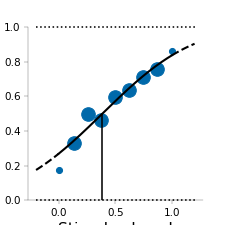

<AxesSubplot:xlabel='Stimulus Level', ylabel='Proportion Correct'>

In [460]:
fig, ax = pl.subplots(figsize=(3,3))
ps.psigniplot.plotPsych(res, axisHandle=ax)


<IPython.core.display.Javascript object>


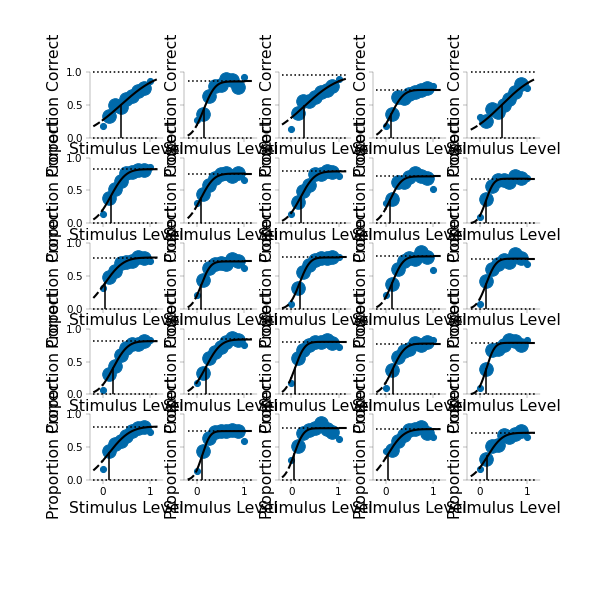

0, Fit: [3.86051215e-01 2.06038735e+00 2.58946579e-07 4.71729551e-05
 3.04810256e-09]
1, Fit: [1.39374215e-01 6.30866734e-01 1.43211417e-01 1.16312191e-08
 6.95664701e-02]
2, Fit: [2.72164751e-01 1.91849611e+00 4.10700131e-02 9.54249533e-08
 3.44196269e-07]
3, Fit: [1.19380055e-01 6.84742069e-01 2.71472614e-01 7.00602275e-09
 7.41219096e-09]
4, Fit: [4.58717301e-01 1.87268451e+00 5.56683432e-09 3.52926241e-06
 3.22969387e-07]
5, Fit: [1.70032604e-01 8.28398379e-01 1.77265108e-01 6.40682241e-08
 1.69746890e-08]
6, Fit: [7.92043364e-02 7.21580195e-01 2.43923562e-01 3.93413741e-08
 4.40426897e-06]
7, Fit: [1.92852406e-01 7.77797872e-01 2.09975622e-01 2.61779285e-08
 2.25276896e-05]
8, Fit: [9.07720154e-02 6.30888096e-01 2.86093172e-01 3.93738885e-06
 1.52043791e-08]
9, Fit: [1.20696473e-01 4.39148447e-01 3.21384739e-01 7.40872961e-05
 7.35334738e-08]
10, Fit: [4.62604801e-02 1.01813715e+00 2.19374209e-01 2.01408144e-08
 1.19767497e-07]
11, Fit: [8.66687119e-02 5.16772415e-01 2.78267406e-0

In [484]:
fig, axn = pl.subplots(5, 5, figsize=(8,8), sharex=True, sharey=True)
f_list=[]
n_iter=25
for ax, ni in zip(axn.flat, np.arange(0, n_iter)):
    data = df.loc[ni][['morph_percent', 'n_chooseB', 'n_samples']].values
    res = ps.psignifit(data, opts)
    print('%i, Fit:' % ni, res['Fit'])
    fit_ = pd.Series(res['Fit'], index=param_names, name=ni)
    f_list.append(fit_)
    ps.psigniplot.plotPsych(res, axisHandle=ax)

# figname = 'fit_%s_%s' % (sigmoid_, animalid)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

pl.subplots_adjust(left=0.15, bottom=0.2, wspace=0.3, hspace=0.3)

In [489]:
f_list=[]
n_iter=100
for ni in np.arange(0, n_iter):
    data = df.loc[ni][['morph_percent', 'n_chooseB', 'n_samples']].values
    res = ps.psignifit(data, opts)
    fit_ = pd.Series(res['Fit'], index=param_names, name=ni)
    f_list.append(fit_)

fitdf = pd.concat(f_list, axis=1).T
fitdf.head()

,threshold,width,lambda,gamma,eta
0,0.386051,2.060387,2.589466e-07,4.717296e-05,3.048103e-09
1,0.139374,0.630867,1.432114e-01,1.163122e-08,6.956647e-02
2,0.272165,1.918496,4.107001e-02,9.542495e-08,3.441963e-07
3,0.119380,0.684742,2.714726e-01,7.006023e-09,7.412191e-09
4,0.458717,1.872685,5.566834e-09,3.529262e-06,3.229694e-07


<IPython.core.display.Javascript object>


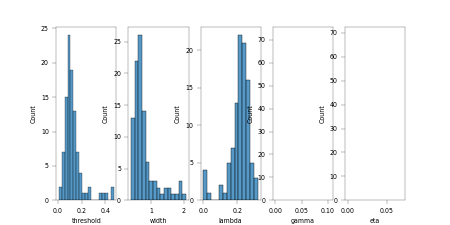

In [490]:

fig, axn = pl.subplots(1, len(param_names), figsize=(6,3))
for ax, param in zip(axn.flat, param_names):
    sns.histplot(x=param, data=fitdf, ax=ax, stat='count')
    

# test_type='morph_single'

In [175]:
# plotd = mean_df[mean_df['n_cells']<=max_ncells].copy()
finaldf['novel_labels'] = None
finaldf.loc[finaldf['novel'], 'novel_labels'] = 'novel'
finaldf.loc[~finaldf['novel'], 'novel_labels'] = 'trained'
#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
novel_colors = {'trained': '', 'novel': (1,1)}

novel_colors = {'trained': [0.3]*3, 'novel': [0.7]*3}

In [176]:
# for k, g in mean_df.groupby(['n_cells', 'visual_area', 'condition', 'intact', 
#                  'train_transform', 'novel', 'morphlevel']):
#     g

In [234]:
curr_ncells=max_ncells
count_cols = ['visual_area', 'morphlevel', 'train_transform', 'test_case']

finaldf['test_case'] = ['novel' if n else 'trained' for n in finaldf['novel']]
datad = finaldf[(finaldf.condition=='data') & (finaldf.intact)
              & (finaldf.n_cells==curr_ncells)]
mean_by_iter = datad.groupby(count_cols+['iteration']).mean()\
                     .reset_index()
print(mean_by_iter['train_transform'].unique())

[10. 20. 30. 40. 50.]


In [235]:
n_iterations = float(iterdf['iteration'].max() +1)
assert mean_by_iter.groupby(count_cols)\
    ['iteration'].count().max() == n_iterations, "Wrong iters: %.2f" % n_iterations

In [306]:
#### Set colors
metric='p_chooseB'
sz_cmap='viridis_r'
dashes={'trained': '', 'novel': (4,2)}
sizes = sorted(mean_by_iter['train_transform'].unique())
print(sizes)
sz_cols = sns.color_palette(sz_cmap, n_colors=len(sizes))
sz_colors = dict((k, v) for k, v in zip(sizes, sz_cols))

[10.0, 20.0, 30.0, 40.0, 50.0]


## Average morph curves (test on trained)

<IPython.core.display.Javascript object>


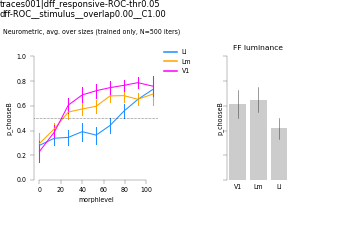

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 neurometric_avg_train_configs__trained-only


In [352]:
plotd = mean_by_iter[mean_by_iter.test_case=='trained']\
            .groupby(['visual_area', 'morphlevel', 'iteration']).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(4.5, 3), sharex=False, sharey=True)
ax=axn[0]
sns.lineplot(x='morphlevel', y=metric, ax=ax, data=plotd[plotd.morphlevel!=-1], 
            hue='visual_area', err_style='bars', ci='sd', 
            palette=area_colors, err_kws={'lw': 1}, lw=1)
ax.legend(bbox_to_anchor=(1., 1.1), loc='upper left', frameon=False)
ax.axhline(y=0.5, ls=':', lw=0.5, color='k')
ax.set_ylim([0, 1])
pplot.set_morph_xticks(ax) 
sns.despine(trim=True, ax=ax)

ax=axn[1]
sns.barplot(x='visual_area', y='p_chooseB', ax=ax, 
            data=plotd[plotd.morphlevel==-1],
            ci='sd', order=visual_areas, color=[0.8]*3,
            errwidth=0.5)
ax.set_title('FF luminance')
ax.set_aspect(6, anchor='C')
ax.set_xlabel('')
ax.tick_params(which='both', axis='x', size=0)
sns.despine(trim=True, bottom=True, ax=ax)

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.75, wspace=0.3)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
fig.text(0.01, 0.85, \
         'Neurometric, avg. over sizes (trained only, N=%i iters)' % n_iterations)
figname = 'neurometric_avg_train_configs__trained-only'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## Average morph curves (trained vs. novel test configs)

<IPython.core.display.Javascript object>


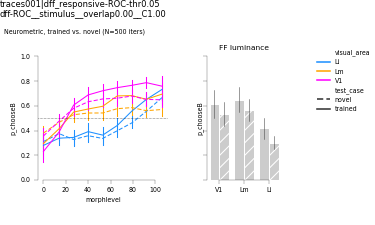

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 neurometric_avg_train_configs__trained-v-novel


In [354]:
plotd = mean_by_iter.groupby(['visual_area', 'morphlevel', 'iteration', 'test_case'])\
                .mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(5, 3), sharex=False, sharey=True)
ax=axn[0]
sns.lineplot(x='morphlevel', y=metric, ax=ax, data=plotd[plotd.morphlevel!=-1], 
            hue='visual_area', palette=area_colors, 
            style='test_case', dashes=dashes, err_style='bars', ci='sd', 
            err_kws={'lw': 1}, lw=1)
ax.legend(bbox_to_anchor=(2.1, 1.1), loc='upper left', frameon=False)
ax.axhline(y=0.5, ls=':', lw=0.5, color='k')
ax.set_ylim([0, 1])
pplot.set_morph_xticks(ax) 
sns.despine(trim=True, ax=ax)

ax=axn[1]
sns.barplot(x='visual_area', y='p_chooseB', ax=ax, 
            data=plotd[plotd.morphlevel==-1], hue='test_case',
            ci='sd', order=visual_areas, hue_order=['trained', 'novel'],
            palette={'trained': [0.8]*3, 'novel': [0.8]*3}, errwidth=0.5,
           edgecolor='w')
bar_locs = 3
hatches = itertools.cycle(['', '//'])
for i, bar in enumerate(ax.patches):
    if i % bar_locs == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)
ax.set_aspect(6, anchor='SW')
ax.legend_.remove()
ax.set_xlabel('')
ax.set_title('FF luminance')
ax.set_aspect(5, anchor='SW')
ax.tick_params(which='both', axis='x', size=0)
sns.despine(trim=True, bottom=True, ax=ax)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75, wspace=0.3)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
fig.text(0.01, 0.85, 'Neurometric, trained vs. novel (N=%i iters)' % n_iterations)
figname = 'neurometric_avg_train_configs__trained-v-novel'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

# Neurometric, splt by train config (trained only)

[10.0, 20.0, 30.0, 40.0, 50.0]


<IPython.core.display.Javascript object>


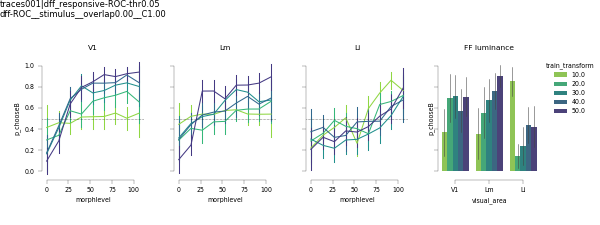

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 pchooseB_overlay_hue_test-on-trained


In [304]:
plotd = mean_by_iter[mean_by_iter.test_case=='trained']

fig, axn = pl.subplots(1,4, figsize=(8, 3), sharex=False, sharey=True)
for va, vg in plotd[plotd.morphlevel!=-1].groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.lineplot(x='morphlevel', y=metric, ax=ax, data=vg, 
                #style='test_case', dashes=dashes,
                hue='train_transform', err_style='bars', ci='sd', 
                palette=sz_colors, err_kws={'lw': 1}, lw=1)
    ax.set_title(va)
    ax.legend_.remove()
    ax.axhline(y=0.5, ls=':', lw=0.5, color='k')
    ax.set_ylim([0, 1])
    pplot.set_morph_xticks(ax) 
    sns.despine(trim=True, ax=ax)

ax=axn[3]
sns.barplot(x='visual_area', y='p_chooseB', ax=ax, 
            data=plotd[plotd.morphlevel==-1],
            hue='train_transform', ci='sd', order=visual_areas, palette=sz_colors,
            errwidth=0.5)
ax.set_title('FF luminance')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
              title='train_transform')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(trim=True, bottom=True, ax=ax)

pl.subplots_adjust(left=0.07, right=0.9, bottom=0.2, top=0.75, wspace=0.3)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
figname = 'pchooseB_overlay_hue_test-on-trained'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## Neurometric, split by config (trained v novel)

<IPython.core.display.Javascript object>


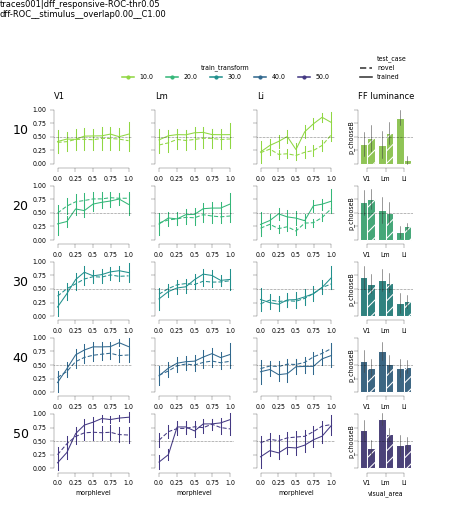

In [305]:
fig, axn = pl.subplots(len(sizes), 4, figsize=(6, 7), sharex=False, sharey=True)
for si, (sz, sg) in enumerate(mean_by_iter.groupby(['train_transform'])):
    for va, vg in sg[sg.morphlevel!=-1].groupby('visual_area'):
        ax=axn[si, visual_areas.index(va)]
        sns.lineplot(x='morphlevel', y=metric, ax=ax, data=vg, 
                    style='test_case', dashes=dashes,
                    hue='train_transform', err_style='bars', ci='sd', 
                    palette=sz_colors, err_kws={'lw': 1}, lw=1)
        pplot.set_morph_xticks(ax) 
#         ax.set_xticks(np.linspace(0, 106, 5))
#         ax.set_xticklabels(np.linspace(0, 1, 5))
        if si==0:
            ax.set_title(va, loc='left', fontsize=8)
        #ax.legend_.remove()
    ax.set_ylabel(int(sz), rotation=0, ha='right', fontsize=12)
    sns.despine(trim=True, ax=ax)

    ax=axn[si, 3]
    bardf = sg[sg.morphlevel==-1]
    sns.barplot(x='visual_area', y='p_chooseB', ax=ax, 
                data=bardf, order=visual_areas, edgecolor='w',
                hue='test_case', ci='sd', hue_order=['trained', 'novel'],
                palette={'trained': sz_colors[sz], 'novel': sz_colors[sz]},
                errwidth=0.5)
    bar_locs = len(bardf.visual_area.unique())
    hatches = itertools.cycle(['', '//'])
    for i, bar in enumerate(ax.patches):
        if i % bar_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
    ax.set_aspect(3, anchor='SW')
    #ax.legend_.remove()
    if si==0:   
        ax.set_title('FF luminance', loc='left', fontsize=8)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    sns.despine(trim=True, bottom=True, ax=ax)
        
for ai, ax in enumerate(axn.flat):
    #ax.legend_.remove()
    ax.axhline(y=0.5, ls=':', color='k', lw=0.5)
    #ax = axn[0, 2]
    if ai==3:  # Add LINEPLOT legend to far right
        leg_h = axn.flat[4].legend_.legendHandles[2:]
        ax.legend(handles=leg_h, bbox_to_anchor=(1,1.3), loc='lower right', 
                  frameon=False)
    elif ai==2: # Add COLOR LEGEND next to it
        leg_h = pplot.custom_legend_markers(colors=[sz_colors[s] for s in sizes],
                                           labels=sizes, marker='.')
        ax.legend(handles=leg_h, bbox_to_anchor=(1,1.3), loc='lower right',
                 frameon=False, title='train_transform', ncol=len(sizes))
    else:
        ax.legend_.remove()
pl.subplots_adjust(left=0.12, right=0.97, bottom=0.1, top=0.8, wspace=0.3, hspace=0.2)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))


figname = 'pchooseB_grid_hue_size_novel-v-trained'

pl.savefig(os.path.join(curr_dst_dir, '%s.svg' %figname))

In [296]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00'

In [ ]:
ax.legend(nc)

In [251]:
leg_h = ax.legend_.legendHandles[2:]
ax.legend(handles=leg_h, bbox_to_anchor


# Example FOV

In [513]:
print(experiment)
dk = '20191006_JC110_fov1'
va = 'V1'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

gratings


In [10]:
# dk = '20190616_JC097_fov1'
# va = 'V1'
print(experiment)
sdf = aggr.get_master_sdf(experiment)

blobs


In [11]:


class_name='morphlevel' if experiment=='blobs' else 'ori'
if experiment=='gratings':
    variation_name = None
else:
    variation_name = None if test_type is None else 'size'
variation_values=None
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None
print(class_name, class_a, class_b)
class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()
clf_params={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            'return_clf': False,
            'verbose': False}

morphlevel 0 106


In [514]:
# stimuli
sdf = aggr.get_stimuli(dk, experiment)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [523]:
import copy
inargs = copy.copy(clf_params)


In [524]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [525]:
inum=3
test_type=None
i_df = dec.select_test(inum, test_type, ndf_z, sdf, **inargs)
i_df

... 3 - selecting


,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,n_cells,n_trials,iteration
3,0.472028,0.010411,0.255849,0.835691,0.289775,0.094974,0.418057,0.304688,1.0,606,data,93,1280,3
3,1.024186,0.010827,0.127958,0.648679,0.079508,-0.012930,0.114706,0.136719,1.0,606,shuffled,93,1280,3


In [509]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [538]:
neuraldf = ndf_z.copy()
tvals = neuraldf.index.tolist()
neuraldf.loc[neuraldf.index, 'trial'] = tvals         


In [526]:
res = dec.fit_svm_mp(ndf_z, sdf, None, n_iterations=10, n_processes=1,
              **clf_params)

... 0 - selecting
--> Elapsed time: 12.50sec
... 1 - selecting
--> Elapsed time: 12.42sec
... 2 - selecting
--> Elapsed time: 12.68sec
... 3 - selecting
--> Elapsed time: 11.49sec
... 4 - selecting
--> Elapsed time: 13.12sec
... 5 - selecting
--> Elapsed time: 12.25sec
... 6 - selecting
--> Elapsed time: 12.25sec
... 7 - selecting
--> Elapsed time: 11.91sec
... 8 - selecting
--> Elapsed time: 11.87sec
... 9 - selecting
--> Elapsed time: 12.10sec


In [533]:
res[['train_score', 'test_score', 'heldout_test_score', 'condition']].groupby(['condition']).describe()

train_score                                                    \
                count      mean       std       min       25%       50%   
condition                                                                 
data             10.0  0.840819  0.010435  0.827876  0.831909  0.839475   
shuffled         10.0  0.616845  0.010824  0.597910  0.614318  0.617431   

                              test_score            ...                      \
                75%       max      count      mean  ...       75%       max   
condition                                           ...                       
data       0.848389  0.859373       10.0  0.258572  ...  0.265328  0.275371   
shuffled   0.621334  0.634036       10.0  0.124227  ...  0.133576  0.138661   

          heldout_test_score                                                   \
                       count      mean       std      min       25%       50%   
condition                                                                       
data                    10.0  0.273828  0.030002  0.21875  0.254883  0.275391   
shuffled                10.0  0.129688  0.023567  0.09375  0.110352  0.136719   

                               
                75%       max  
condition                      
data       0.294922  0.320312  
shuffled   0.146484  0.160156  

[2 rows x 24 columns]

In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


In [376]:
# inum =2
# res = dec.train_test_size

In [436]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_subset(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


In [437]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.006387,0.000969,0.706091,1.0,0.040743,0.045418,0.058780,0.641509,1.0,7228,data,10_20_30_40,10_20_30_40,264,False,2,221
1,0.008795,0.001038,0.492802,1.0,0.022424,0.019121,0.032351,0.396226,1.0,7228,shuffled,10_20_30_40,10_20_30_40,264,False,2,221
2,0.006387,0.000969,0.706091,1.0,0.084611,0.119522,0.122068,0.686567,1.0,7228,data,10_20_30_40,50.0,67,True,2,221
3,0.006277,0.000910,0.663677,1.0,0.102707,0.137532,0.148175,0.716981,1.0,9823,data,10_20_30_50,10_20_30_50,264,False,2,221
4,0.007357,0.000959,0.502436,1.0,0.000147,-0.014046,0.000213,0.490566,1.0,9823,shuffled,10_20_30_50,10_20_30_50,264,False,2,221
5,0.006277,0.000910,0.663677,1.0,0.111929,0.152264,0.161479,0.731343,1.0,9823,data,10_20_30_50,40.0,67,True,2,221
6,0.005600,0.000857,0.682835,1.0,0.001548,-0.011960,0.002234,0.528302,1.0,5767,data,10_20_40_50,10_20_40_50,264,False,2,221
7,0.008921,0.001029,0.426135,1.0,0.004288,-0.008155,0.006187,0.547170,1.0,5767,shuffled,10_20_40_50,10_20_40_50,264,False,2,221
8,0.005600,0.000857,0.682835,1.0,0.046699,0.058313,0.067372,0.647059,1.0,5767,data,10_20_40_50,30.0,68,True,2,221
9,0.005312,0.000805,0.668217,1.0,0.052276,0.062297,0.075418,0.660377,1.0,1688,data,10_30_40_50,10_30_40_50,264,False,2,221


In [430]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [431]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_single(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


1.0
(4,)
1.0
(4,)
0.610909090909091
(4,)
0.0020420074462890623
(4,)
0.0006659507751464843
(4,)
6564
(4,)
10.0
(4,)
1.0
(4,)
1.0
(4,)
0.7654545454545454
(4,)
0.0014920711517333984
(4,)
0.0004935741424560546
(4,)
5899
(4,)
20.0
(4,)
1.0
(4,)
1.0
(4,)
0.7781818181818183
(4,)
0.0015712738037109374
(4,)
0.0005093574523925781
(4,)
6167
(4,)
30.0
(4,)
1.0
(4,)
1.0
(4,)
0.730909090909091
(4,)
0.0014906883239746093
(4,)
0.0005062580108642578
(4,)
1901
(4,)
40.0
(4,)
1.0
(4,)
1.0
(4,)
0.6581818181818182
(4,)
0.0014026165008544922
(4,)
0.00045900344848632814
(4,)
1571
(4,)
50.0
(4,)


In [434]:
res.groupby(['condition', 'novel']).mean()

fit_time  score_time  test_score  train_score  heldout_MI  \
condition novel                                                              
data      False  0.001600    0.000527    0.708727          1.0    0.311854   
          True   0.001600    0.000527    0.708727          1.0    0.066433   
shuffled  False  0.001566    0.000512    0.535636          1.0    0.044120   

                 heldout_aMI  heldout_log2MI  heldout_test_score    C   randi  \
condition novel                                                                 
data      False     0.418541        0.449911            0.828571  1.0  4420.4   
          True      0.087560        0.095842            0.615979  1.0  4420.4   
shuffled  False     0.004287        0.063652            0.385714  1.0  4420.4   

                 train_transform  test_transform  n_trials  iteration  n_cells  
condition novel                                                                 
data      False             30.0            30.0      66.8        2.0    221.0  
          True              30.0            30.0      67.4        2.0    221.0  
shuffled  False             30.0            30.0      66.8        2.0    221.0

In [435]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.002042,0.000666,0.610909,1.0,0.051757,0.014048,0.074670,0.642857,1.0,6564,data,10.0,10.0,68,False,2,221
1,0.001622,0.000542,0.536364,1.0,0.010239,-0.045851,0.014772,0.428571,1.0,6564,shuffled,10.0,10.0,68,False,2,221
2,0.002042,0.000666,0.610909,1.0,0.001906,-0.009494,0.002749,0.522388,1.0,6564,data,10.0,20.0,67,True,2,221
3,0.002042,0.000666,0.610909,1.0,0.004072,-0.005124,0.005874,0.455882,1.0,6564,data,10.0,30.0,68,True,2,221
4,0.002042,0.000666,0.610909,1.0,0.015436,0.012156,0.022270,0.417910,1.0,6564,data,10.0,40.0,67,True,2,221
5,0.002042,0.000666,0.610909,1.0,0.011254,0.005980,0.016236,0.447761,1.0,6564,data,10.0,50.0,67,True,2,221
6,0.001492,0.000494,0.765455,1.0,0.178715,0.213523,0.257831,0.785714,1.0,5899,data,20.0,20.0,66,False,2,221
7,0.001532,0.000509,0.536364,1.0,0.094878,0.083770,0.136879,0.285714,1.0,5899,shuffled,20.0,20.0,66,False,2,221
8,0.001492,0.000494,0.765455,1.0,0.000000,-0.010967,0.000000,0.500000,1.0,5899,data,20.0,10.0,68,True,2,221
9,0.001492,0.000494,0.765455,1.0,0.148230,0.205488,0.213851,0.764706,1.0,5899,data,20.0,30.0,68,True,2,221


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


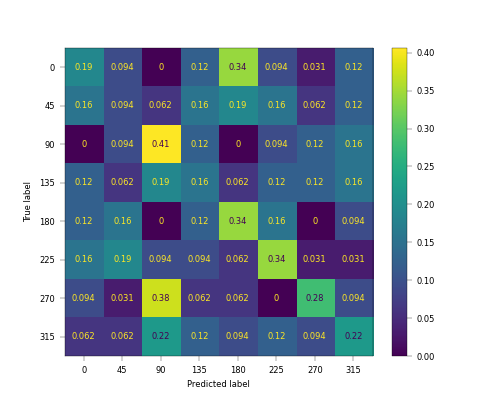

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")